In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Do unfolding

In [5]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,SysUnc,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            tunfolderData.AddSysError(SysUnc[source+ud],source+ud,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfoldSys.kSysErrModeMatrix)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    Data_unfolded_TotalUnc=Data_unfolded.Clone("Data_unfolded_TotalUnc")
    Data_unfolded_SysUnc=Data_unfolded.Clone("Data_unfolded_SysUnc")
    Data_unfolded_StatUnc=Data_unfolded.Clone("Data_unfolded_StatUnc")
    Unc_unfolded_Total=Data_unfolded.Clone("Total Uncertainties")
    Unc_unfolded_Total.Reset()
    Unc_unfolded_Sys=Data_unfolded.Clone("Systematic Uncertainties")
    Unc_unfolded_Sys.Reset()
    Unc_unfolded_SysSeries={}
    Unc_unfolded_Stat=Data_unfolded.Clone("Statistical Uncertainties")
    Unc_unfolded_Stat.Reset()
    
    cov_total=tunfolderData.GetEmatrixTotal("Total Covariance Matrix")
    cov_uncorr=tunfolderData.GetEmatrixSysUncorr("Covariance Matrix from Uncorrelated Uncertainties")
    cov_input=tunfolderData.GetEmatrixInput("Covariance Matrix from Stat Uncertainties of Input Data")
    
    N=Data_unfolded.GetNbinsX()
    
    for i in range(1,N+1):
        stat1=cov_uncorr.GetBinContent(i,i)
        stat2=cov_input.GetBinContent(i,i)
        Data_unfolded_StatUnc.SetBinError(i,np.sqrt(stat1+stat2))
        Unc_unfolded_Stat.SetBinContent(i,np.sqrt(stat1+stat2))

    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            Unc_unfolded_SysSeries[source+ud]=tunfolderData.GetDeltaSysSource(source+ud, "Systematic Uncertainties:"+source+ud, "-1#sigma")
        Unc_unfolded_SysSeries[source+"Total"]=Unc_unfolded_SysSeries[source+"Up"].Clone("Systematic Uncertainties:"+source+"Total")
        Unc_unfolded_SysSeries[source+"Total"].Reset()
        for i in range(1,N+1):
            sys1=Unc_unfolded_SysSeries[source+"Up"].GetBinContent(i)
            sys2=Unc_unfolded_SysSeries[source+"Down"].GetBinContent(i)
            Unc_unfolded_SysSeries[source+"Total"].SetBinContent(i,np.sqrt(sys1**2+sys2**2))
        Unc_unfolded_Sys.Add(Unc_unfolded_SysSeries[source+"Total"])
    for i in range(1,N+1):
        Data_unfolded_SysUnc.SetBinError(i,Unc_unfolded_Sys.GetBinContent(i))
        
    for i in range(1,N+1):
        stat=Unc_unfolded_Stat.GetBinContent(i)
        sys=Unc_unfolded_Sys.GetBinContent(i)
        total=np.sqrt(stat**2+sys**2)
        Data_unfolded_TotalUnc.SetBinError(i,total)
        Unc_unfolded_Total.SetBinContent(i,total)
    
    corr=cov_total.Clone("Correlation")
    corr.Reset()
    for i in range(1,N+1):
        ex=np.sqrt(cov_total.GetBinContent(i,i))
        for j in range(1,N+1):
            ey=np.sqrt(cov_total.GetBinContent(j,j))
            corr.SetBinContent(i,j,cov_total.GetBinContent(i,j)/ex/ey)
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    Data_unfolded_TotalUnc.SetMarkerStyle(22)
    Data_unfolded_TotalUnc.SetMarkerColor(1)
    Data_unfolded_TotalUnc.SetLineColor(16)
    Data_unfolded_TotalUnc.SetLineWidth(2)
    
    Data_unfolded_SysUnc.SetMarkerStyle(22)
    Data_unfolded_SysUnc.SetMarkerColor(1)
    Data_unfolded_SysUnc.SetLineColor(1)
    Data_unfolded_SysUnc.SetLineWidth(2)
    
    Unc_unfolded_Total.SetMarkerStyle(22)
    Unc_unfolded_Total.SetMarkerColor(16)
    Unc_unfolded_Total.SetLineColor(16)
    Unc_unfolded_Total.SetLineWidth(2)
    
    Unc_unfolded_Sys.SetMarkerStyle(22)
    Unc_unfolded_Sys.SetMarkerColor(1)
    Unc_unfolded_Sys.SetLineColor(1)
    Unc_unfolded_Sys.SetLineWidth(2) 
    
    Unc_unfolded_Stat.SetMarkerStyle(22)
    Unc_unfolded_Stat.SetMarkerColor(8)
    Unc_unfolded_Stat.SetLineColor(8)
    Unc_unfolded_Stat.SetLineWidth(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    
    hs.Add(Data_unfolded_TotalUnc,"E")
    hs.Add(Data_unfolded_SysUnc,"E")
    
    hs_unc=rt.THStack("Uncertainties "+HSname,"Uncertainties "+HSname,)
    hs_unc.Add(Unc_unfolded_Total,"Hist")
    hs_unc.Add(Unc_unfolded_Sys,"Hist")
    hs_unc.Add(Unc_unfolded_Stat,"Hist")
    
    leg=rt.TLegend(0.3, 0.1, 0.9, 0.5)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded_TotalUnc,"Data_unfolded with total uncertainties",'lep')
    leg.AddEntry(Data_unfolded_SysUnc,"Data_unfolded with systematic uncertainties",'lep')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    leg_unc=rt.TLegend(0.15, 0.5, 0.55, 0.8)
    leg_unc.AddEntry(Unc_unfolded_Total,"Total uncertainties","f")
    leg_unc.AddEntry(Unc_unfolded_Sys,"Systematics uncertainties","f")
    leg_unc.AddEntry(Unc_unfolded_Stat,"Statistical uncertainties","f")
    leg_unc.SetLineColor(0)
    leg_unc.SetBorderSize(0)
    leg_unc.SetFillStyle(0)
    
    return hs,ratio,leg,hs_unc,leg_unc,corr

# $\tau_{21}$

In [6]:
reco='recoJetTau21_nom_dijetSel'
gen='genJetTau21_dijetSel'
response='respJetTau21_nom_dijetSel'
sysunc={}
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        sysunc[source+ud]='respJetTau21_'+source+ud+'_dijetSel'
        print sysunc[source+ud]

respJetTau21_jesTotalUp_dijetSel
respJetTau21_jesTotalDown_dijetSel
respJetTau21_jerUp_dijetSel
respJetTau21_jerDown_dijetSel
respJetTau21_puUp_dijetSel
respJetTau21_puDown_dijetSel


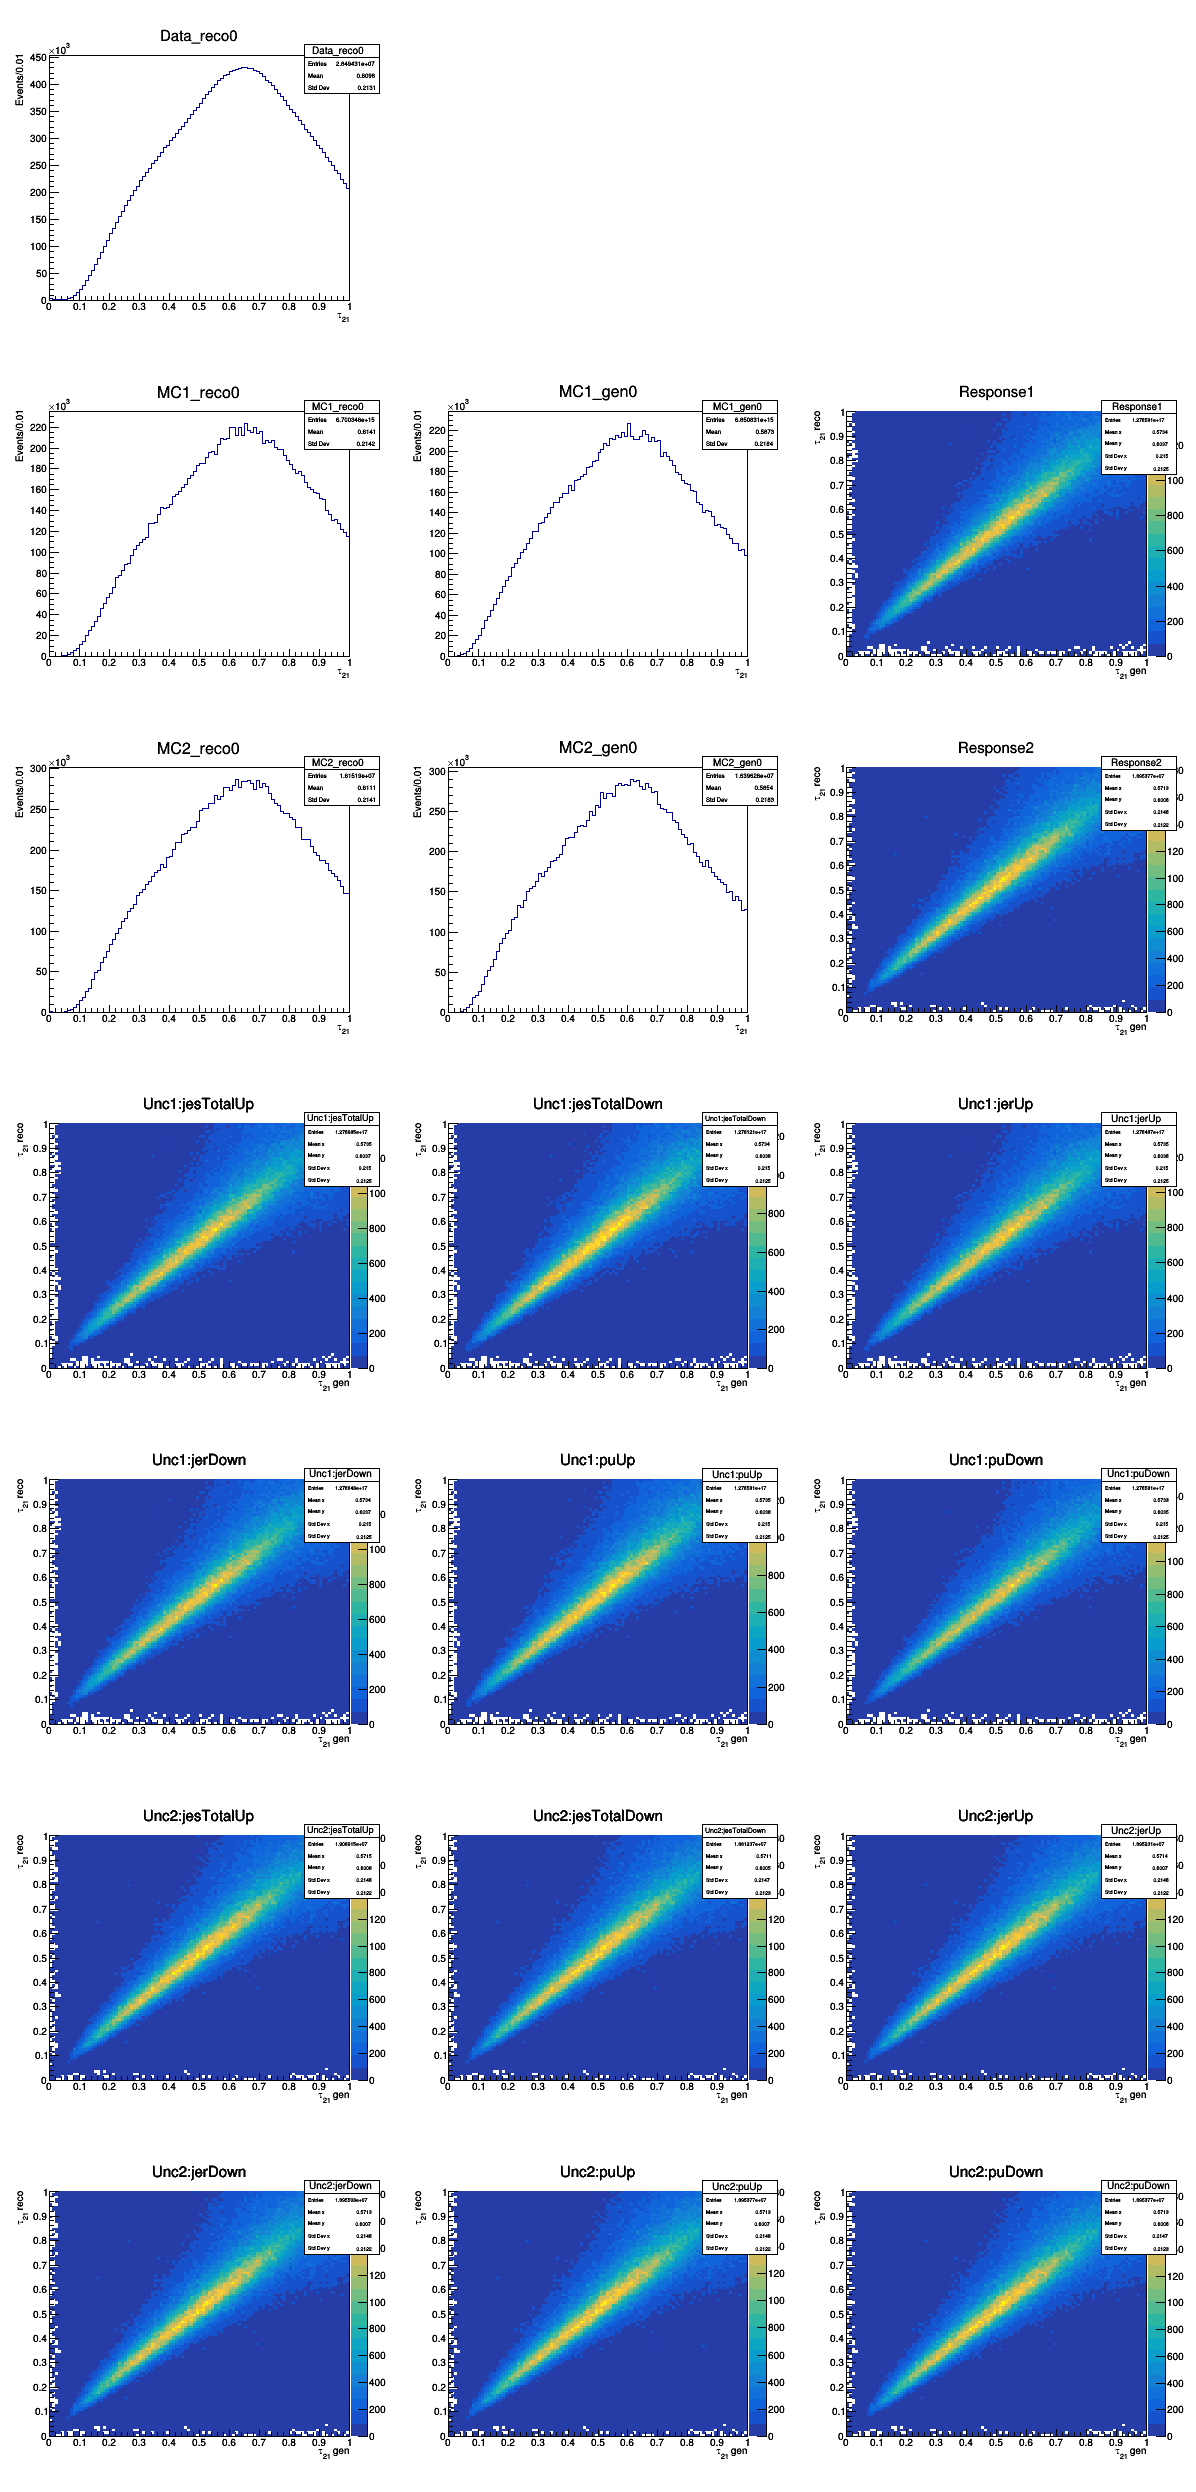

In [7]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{21};Events/0.01",100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{21};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{21};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{21};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{21};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{21} gen;#tau_{21} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{21} gen;#tau_{21} reco",100,0,1,100,0,1)
SysUnc1_0={}
SysUnc2_0={}
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        SysUnc1_0[source+ud]=rt.TH2D('Unc1:'+source+ud,'Unc1:'+source+ud+';#tau_{21} gen;#tau_{21} reco',100,0,1,100,0,1)
        SysUnc2_0[source+ud]=rt.TH2D('Unc2:'+source+ud,'Unc2:'+source+ud+';#tau_{21} gen;#tau_{21} reco',100,0,1,100,0,1)
    
f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
#MC1_reco0.Add(t.Get(reco),Scale[i])
#MC1_gen0.Add(t.Get(gen),Scale[i])
MC1_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
MC1_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        SysUnc1_0[source+ud].Add(t.Get(sysunc[source+ud]),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            SysUnc2_0[source+ud].Add(t.Get(sysunc[source+ud]),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,2520)
c0.Divide(3,7)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()
i=10
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        c0.cd(i)
        SysUnc1_0[source+ud].Draw("Colz")
        i+=1
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        c0.cd(i)
        SysUnc2_0[source+ud].Draw("Colz")
        i+=1

In [8]:
gen_bins=np.array([x for x in np.linspace(num=12,start=0.12,stop=1)])
gen_bins=np.concatenate((np.array([0.]),gen_bins))
reco_bins=np.array([x for x in np.linspace(num=23,start=0.12,stop=1)])
reco_bins=np.concatenate((np.array([0.,0.06]),reco_bins))
print gen_bins,gen_bins.shape[0]-1
print reco_bins,reco_bins.shape[0]-1

[0.   0.12 0.2  0.28 0.36 0.44 0.52 0.6  0.68 0.76 0.84 0.92 1.  ] 12
[0.   0.06 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56
 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ] 24


In [9]:
gen_bin=gen_bins
reco_bin=reco_bins
    
Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{21};Events",reco_bin.shape[0]-1,reco_bin)
MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{21};Events",reco_bin.shape[0]-1,reco_bin)
MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{21};Events",gen_bin.shape[0]-1,gen_bin)
Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{21} gen;#tau_{21} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
SysUnc2={}
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        SysUnc2[source+ud]=rt.TH2D('Unc:'+source+ud,'Unc:'+source+ud+';#tau_{21} gen;#tau_{21} reco',gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)

Fill1D(Data_reco0,Data_reco,reco_bin)
Fill1D(MC2_reco0,MC2_reco,reco_bin)
Fill1D(MC2_gen0,MC2_gen,gen_bin)
Fill2D(Response2_0,Response2,gen_bin,reco_bin)
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        Fill2D(SysUnc2_0[source+ud],SysUnc2[source+ud],gen_bin,reco_bin)

Response2.SetTitle("Response Matrix #tau_{21} binning %d"%(i+1))
Response2.SetStats(0)
    
Data_reco.Scale(1.0/Data_reco.Integral())
MC2_reco.Scale(1.0/MC2_reco.Integral())
MC2_gen.Scale(1.0/MC2_gen.Integral())
    
hs,ratio,leg,hs_unc,leg_unc,corr=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,SysUnc2,"#tau_{21}","QCD",gen_bin)
    
hs.SetTitle("#tau_{21}")
ratio.SetTitle("Ratios")

Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 24 input bins and 12 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{21} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #13 (xaxis:#tau_{21} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 24 input bins and 12 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{21} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #13 (xaxis:#tau_{21} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]


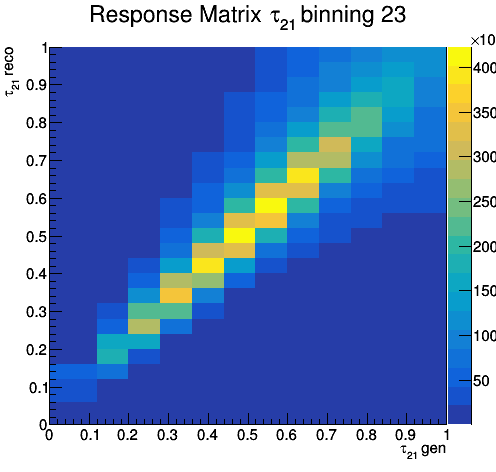

In [10]:
c=rt.TCanvas("Response","Response",0,0,500,500)
Response2.Draw("Colz")
c.Draw()

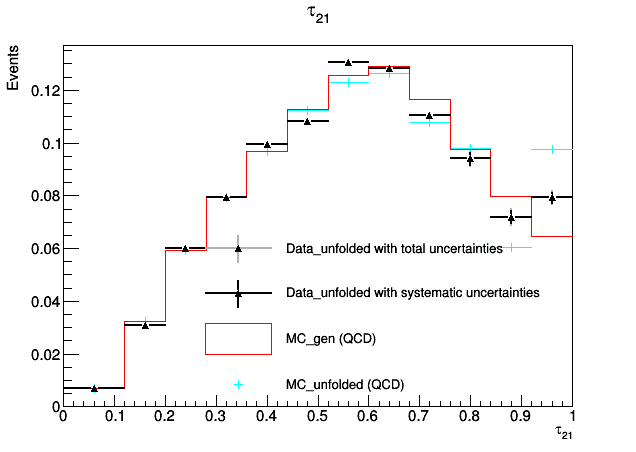

In [11]:
c=rt.TCanvas("Unfolded","Unfolded",0,0,640,480)
hs.Draw("nostack")
hs.GetXaxis().SetTitle("#tau_{21}")
hs.GetYaxis().SetTitle("Events")
leg.Draw("Same")
c.Draw()

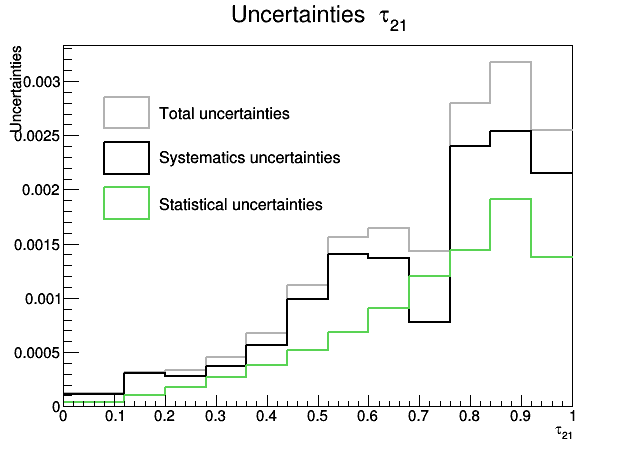

In [12]:
c=rt.TCanvas("Uncertainties","Uncertainties",0,0,640,480)
hs_unc.Draw("nostack")
hs_unc.GetXaxis().SetTitle("#tau_{21}")
hs_unc.GetYaxis().SetTitle("Uncertainties")
hs_unc.GetYaxis().SetTitleOffset(1.35)
leg_unc.Draw("Same")
c.Draw()

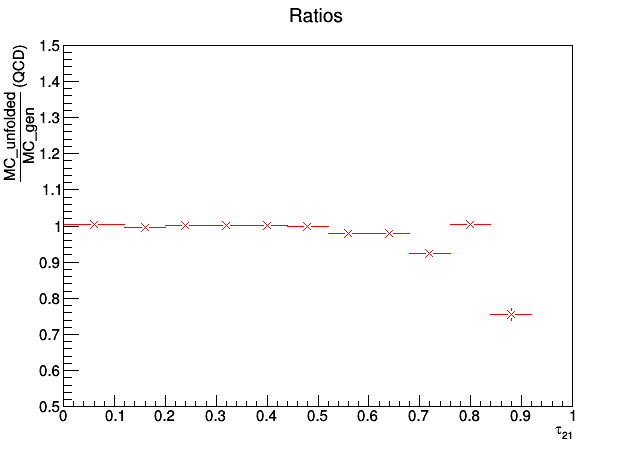

In [13]:
c=rt.TCanvas("Ratios","Ratios",0,0,640,480)
ratio.Draw()
c.Draw()

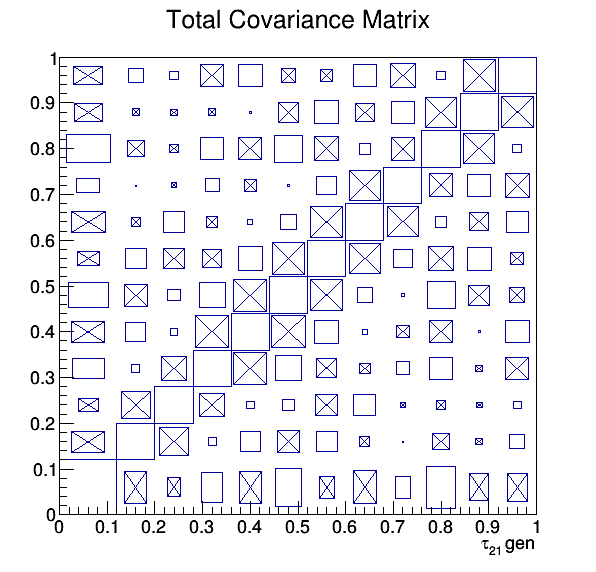

In [14]:
c=rt.TCanvas("Correlation","Correlation",0,0,600,600)
corr.SetStats(0)
corr.Draw("box")
c.Draw()